In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Load dataset
df = pd.read_csv("f_data_100_10.csv")


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [3]:
var_ar =  df['var_DQ_100_10'].values
cmap1 = plt.get_cmap('coolwarm')
cycles_ar = df['cycles'].values

colors_2_c = [cmap1(1-(x - min(cycles_ar)) / (max(cycles_ar) - min(cycles_ar))) for x in cycles_ar]
plotly_colors = [f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 1)' for color in colors_2_c]

fig_2c_ex = go.Figure()
fig_2c_ex.add_trace(go.Scatter(x=var_ar,
                          y=cycles_ar,

  mode='markers',marker=dict(size=22,color=plotly_colors,
            opacity=1, )))
fig_2c_ex.update_layout( yaxis = dict(type='log',title = 'Cycle life',range=[2,4]),
                  xaxis=dict( range = [-8,-1], # define the range of x-axis range=[-0.002,0.]
                            title='Var ΔQ100_10(V)',  # optional title
                             type='log'
                             ))
fig_2c_ex.show()
# CALCULATION OF PEARSON CORRELATION FOR LOG SCALE
cycle_ar_log_scale = np.array([np.log10(c_l) for c_l in cycles_ar])
var_ar_log_scale = np.array([np.log10(va) for va in var_ar])
pear_2C = np.corrcoef(var_ar_log_scale,cycle_ar_log_scale)[0,1]
print(f" The pearson correlation is {pear_2C}")

 The pearson correlation is -0.9159176982572148


In [4]:
def convert_values_tol_log_scale(df_data):
  # lista_log = ['var', 'iqr', 'idr', 'min', 'mean', 'skew', 'kurt', 'mean_cubic','range','cycles']
  lista_log = ['var_DQ_100_10', 'IQR_DQ_100_10', 'IDR_DQ_100_10', 'min_DQ_100_10', 'maxDQ_100_10', 'mean_DQ_100_10', 'skew_100_10', 'kurt_100_10', 'mean_cub_DQ_100_10', 'voltage_295_100_10', 'range_100_10','cycles']
  for el in lista_log:
    if (df_data[el]<0).any():
      df_data[f'{el}'] = df_data[el].apply(lambda x: np.log10(abs(x)))#df_data[f'{el}_log'] = df_data[el].apply(lambda x: np.log10(abs(x)))
    else:
      df_data[f'{el}'] = df_data[el].apply(lambda x: np.log10(x))#df_data[f'{el}_log'] = df_data[el].apply(lambda x: np.log10(x))
  return df_data


def convert_from_log_to_normal(actual,preds):
  pred_actual =  np.round(10**preds,decimals=0)
  values_actual = np.round(10**actual,decimals=0)
  return values_actual,pred_actual

In [5]:
# sos -> how works <-

def compute_relevance(y, kind='extremes', extr_type='high', thres=0.9):
    if kind == 'extremes':
        y = np.array(y)
        perc = np.percentile(y, thres * 100) if extr_type == 'high' else np.percentile(y, (1 - thres) * 100)
        relevance = np.where(y >= perc, 1.0, 0.1) if extr_type == 'high' else np.where(y <= perc, 1.0, 0.1)
        return relevance
    return np.ones_like(y)

def get_weights(strategy, y_train):
    if strategy == "density":
        kde = KernelDensity(kernel='gaussian', bandwidth=100).fit(y_train.reshape(-1, 1))
        log_dens = kde.score_samples(y_train.reshape(-1, 1))
        dens = np.exp(log_dens)
        weights = 1.0 / dens
        weights /= np.mean(weights)
    elif strategy == "relevance":
        rel = compute_relevance(y_train, kind='extremes', extr_type='high', thres=0.9)
        weights = rel
    elif strategy == "hybrid":
        kde = KernelDensity(kernel='gaussian', bandwidth=100).fit(y_train.reshape(-1, 1))
        log_dens = kde.score_samples(y_train.reshape(-1, 1))
        dens = np.exp(log_dens)
        rel = compute_relevance(y_train, kind='extremes', extr_type='high', thres=0.9)
        weights = (1.0 / dens) * rel
        weights /= np.mean(weights)
    else:
        weights = None
    return weights


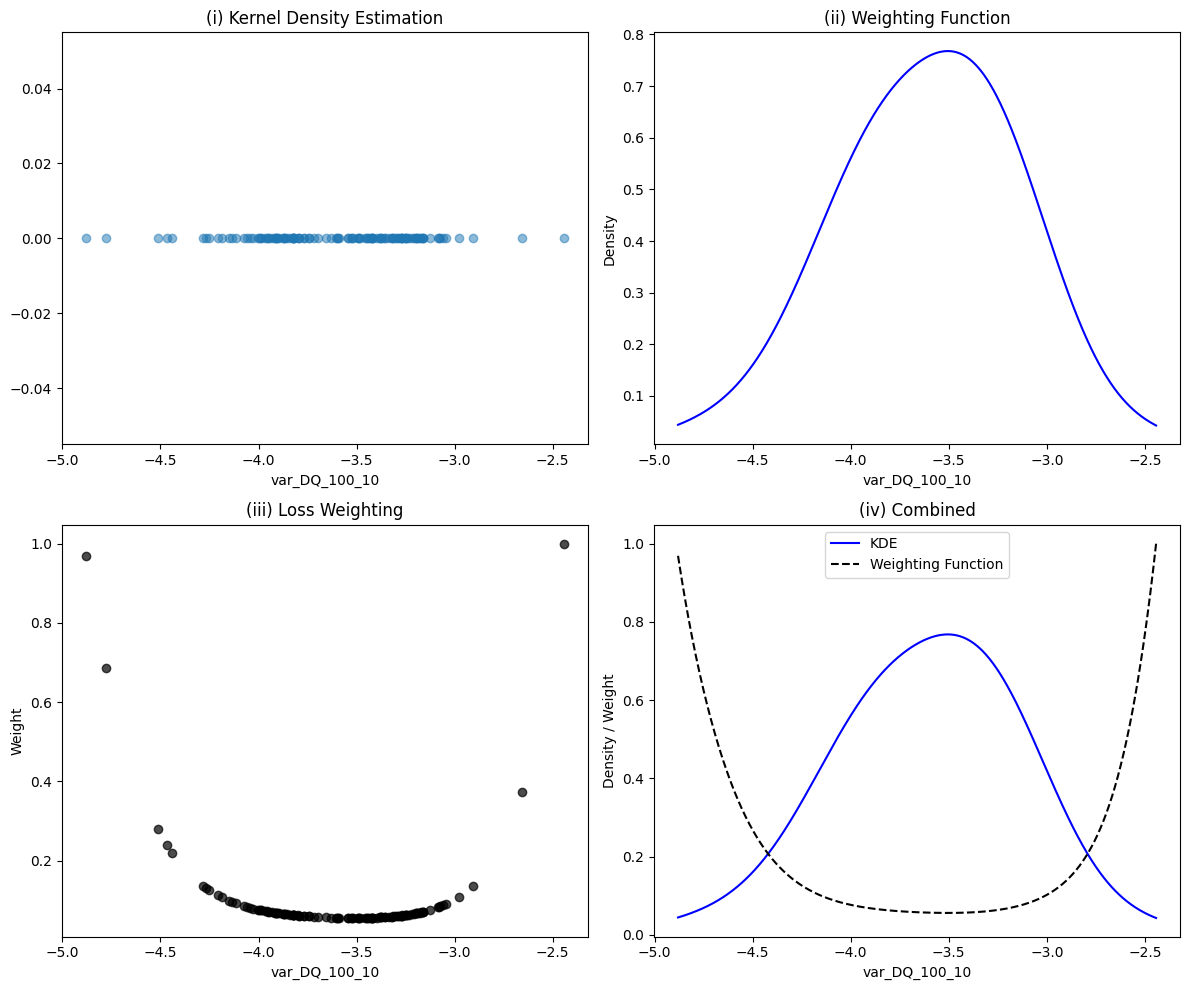

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KernelDensity
from scipy.interpolate import interp1d

# Step 1: Data Preparation
df = convert_values_tol_log_scale(df)  # Assuming this function exists
X = df.drop(columns=["Unnamed: 0", "cycles"])
y = df["cycles"]
var_name = 'var_DQ_100_10'
var_data = df[var_name].values.reshape(-1, 1)

# Step 2: Kernel Density Estimation
kde = KernelDensity(kernel='gaussian', bandwidth=0.3)
kde.fit(var_data)
x_d = np.linspace(var_data.min(), var_data.max(), 1000).reshape(-1, 1)
log_density = kde.score_samples(x_d)
density = np.exp(log_density)

# Step 3: Weighting Function (example: inverse density)
weights_func = 1 / (density + 1e-5)
weights_func /= np.max(weights_func)  # Normalize

# Step 4: Visualizations
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Panel (i): Data Points
axs[0, 0].scatter(var_data, np.zeros_like(var_data), alpha=0.5)
axs[0, 0].set_title('(i) Kernel Density Estimation')
axs[0, 0].set_xlabel(var_name)

# Panel (ii): KDE Line
axs[0, 1].plot(x_d, density, color='blue', label='KDE')
axs[0, 1].set_title('(ii) Weighting Function')
axs[0, 1].set_xlabel(var_name)
axs[0, 1].set_ylabel('Density')

# Panel (iii): Weighting Function as Points
interp_weights_func = interp1d(x_d.flatten(), weights_func, kind='linear', fill_value='extrapolate')
weights_at_data_points = interp_weights_func(var_data.flatten())
axs[1, 0].scatter(var_data, weights_at_data_points, color='black', alpha=0.7)
axs[1, 0].set_title('(iii) Loss Weighting')
axs[1, 0].set_xlabel(var_name)
axs[1, 0].set_ylabel('Weight')

# Panel (iv): Combined KDE and Weighting Function
axs[1, 1].plot(x_d, density, color='blue', label='KDE')
axs[1, 1].plot(x_d, weights_func, color='black', linestyle='--', label='Weighting Function')
axs[1, 1].legend()
axs[1, 1].set_title('(iv) Combined')
axs[1, 1].set_xlabel(var_name)
axs[1, 1].set_ylabel('Density / Weight')

plt.tight_layout()
plt.show()


## Training models - Elastic net / Random forest

In [8]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

# Preprocessing (already done)
# df_log_scale = convert_values_tol_log_scale(df.copy())

# X = df_log_scale.drop(columns=["Unnamed: 0", "cycles"])
# y = df_log_scale["cycles"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
y_train_np = y_train.values

# Weighting strategies
strategies = {
    "No Weights": None,
    "Density-Based": get_weights("density", y_train_np),
    "Relevance-Based": get_weights("relevance", y_train_np),
    "Hybrid": get_weights("hybrid", y_train_np),
}

# Parameter grids
parameter_elastic_net = {
    'alpha': [1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.01, 0.1, 0.4, 0.5, 0.6, 0.9, 1.0],
    'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.78, 0.8, 0.82, 0.85, 0.86, 0.9]
}

parameters_random_forests = {
    'n_estimators': [1, 3, 5, 10, 30, 50, 100],
    'criterion': ['absolute_error'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5]
}

# Define models to train
models_to_train = {
    "ElasticNet": (ElasticNet(), parameter_elastic_net),
    "RandomForest": (RandomForestRegressor(), parameters_random_forests)
}

results = []
predictions = {}

for model_name, (model, param_grid) in models_to_train.items():
    for label, weights in strategies.items():
        grid_search = GridSearchCV(
            model,
            param_grid,
            scoring='neg_mean_absolute_error',
            cv=5,
            n_jobs=-1
        )

        if weights is not None and model_name == "ElasticNet":
            # ElasticNet supports sample_weight in fit
            grid_search.fit(X_train, y_train, sample_weight=weights)
        elif weights is not None and model_name == "RandomForest":
            # RandomForestRegressor supports sample_weight too
            grid_search.fit(X_train, y_train, sample_weight=weights)
        else:
            grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        predictions[f"{model_name} - {label}"] = y_pred

        y_test_actual, y_pred_actual = convert_from_log_to_normal(y_test, y_pred)

        mae = mean_absolute_error(y_test_actual, y_pred_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
        r2 = r2_score(y_test_actual, y_pred_actual)

        results.append({
            "Model": f"{model_name} - {label}",
            "Best Params": grid_search.best_params_,
            "MAE": mae,
            "RMSE": rmse
        })

results_df = pd.DataFrame(results)
results_df


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.591e-02, tolerance: 3.056e-04

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.591e-02, tolerance: 3.056e-04

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.709e-02, tolerance: 4.692e-04

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_des

,Model,Best Params,MAE,RMSE
0,ElasticNet - No Weights,"{'alpha': 1e-06, 'l1_ratio': 0.9}",67.161290,123.345306
1,ElasticNet - Density-Based,"{'alpha': 1e-06, 'l1_ratio': 0.9}",67.161290,123.345306
2,ElasticNet - Relevance-Based,"{'alpha': 1e-06, 'l1_ratio': 0.9}",73.096774,121.907157
3,ElasticNet - Hybrid,"{'alpha': 1e-06, 'l1_ratio': 0.9}",73.096774,121.907157
4,RandomForest - No Weights,"{'criterion': 'absolute_error', 'max_depth': 1...",82.870968,120.900519
5,RandomForest - Density-Based,"{'criterion': 'absolute_error', 'max_depth': N...",95.000000,155.187815
6,RandomForest - Relevance-Based,"{'criterion': 'absolute_error', 'max_depth': N...",76.709677,145.834860
7,RandomForest - Hybrid,"{'criterion': 'absolute_error', 'max_depth': N...",85.064516,134.580231
